In [1]:
from tensorflow import keras 
from keras.models import Model
from keras import Input
from keras.layers import Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.utils import plot_model

from skimage.restoration import (estimate_sigma, denoise_wavelet,
                                 denoise_bilateral, denoise_nl_means)

from numpy.lib.stride_tricks import as_strided as ast
import numpy as np 
from tqdm import tqdm
import matplotlib 
import matplotlib.pyplot as plt
import graphviz
import sys
import os

11490434/11490434 [==============================] - 0s 0us/step


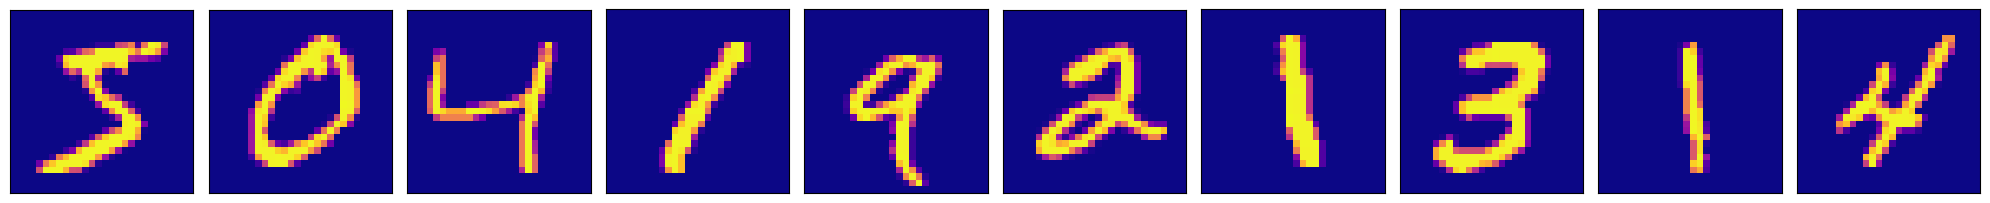

In [2]:
# Load digits data 
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

# Normalize input data
X_train = X_train.astype("float32")/255
X_test = X_test.astype("float32")/255

# Display images of the first 10 digits in the training set and their true lables
fig, axs = plt.subplots(1, 10, sharey=False, tight_layout=True, figsize=(20,3), facecolor='white')
n = 0
for j in range(0,10):
  axs[j].matshow(X_train[n], cmap='plasma')
  axs[j].set_xticks([])
  axs[j].set_yticks([])
  n = n + 1
plt.show()

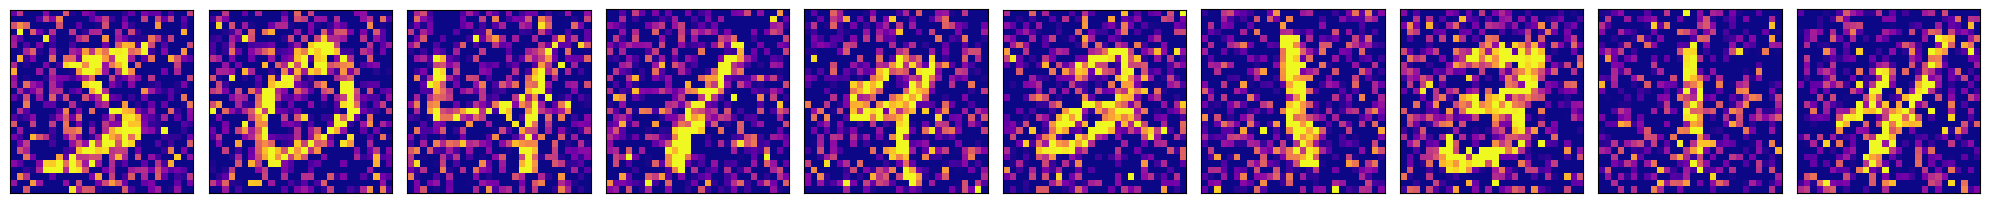

In [3]:
noise_variance=0.15
X_train_noisy = X_train + np.sqrt(noise_variance) * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test + np.sqrt(noise_variance) * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

# Enforce min-max boundaries so it does not go beyond [0,1] range
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

# Display images of the first 10 digits in the noisy training data
fig, axs = plt.subplots(1, 10, sharey=False, tight_layout=True, figsize=(20,3), facecolor='white')
n = 0
for j in range(0,10):
  axs[j].matshow(X_train_noisy[n], cmap='plasma')
  axs[j].set_xticks([])
  axs[j].set_yticks([])
  n = n + 1
plt.show()

In [4]:
# Reshape input data
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

X_train_noisy = X_train_noisy.reshape(60000, 784)
X_test_noisy = X_test_noisy.reshape(10000, 784)

Model: "Denoising-Autoencoder-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input-Layer (InputLayer)    [(None, 784)]             0         
                                                                 
 Encoder-Layer (Dense)       (None, 784)               615440    
                                                                 
 Encoder-Layer-Normalization  (None, 784)              3136      
  (BatchNormalization)                                           
                                                                 
 Encoder-Layer-Activation (L  (None, 784)              0         
 eakyReLU)                                                       
                                                                 
 Middle-Hidden-Layer (Dense)  (None, 784)              615440    
                                                                 
 Decoder-Layer (Dense)       (None, 784

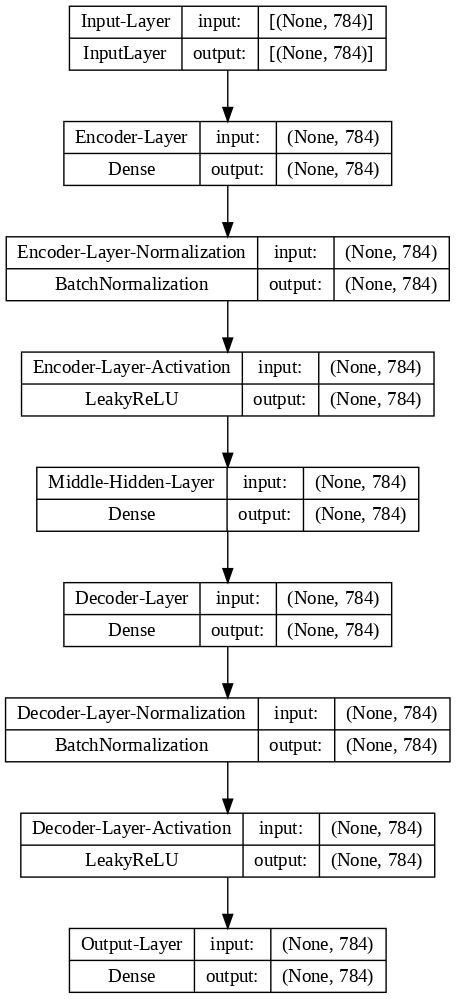

In [5]:
#--- Define Shapes
n_inputs = X_train.shape[1] # number of input neurons = the number of features X_train

#--- Input Layer 
visible = Input(shape=(n_inputs,), name='Input-Layer') # Specify input shape

#--- Encoder Layer
e = Dense(units=n_inputs, name='Encoder-Layer')(visible)
e = BatchNormalization(name='Encoder-Layer-Normalization')(e)
e = LeakyReLU(name='Encoder-Layer-Activation')(e)

#--- Middle Layer
middle = Dense(units=n_inputs, activation='linear', activity_regularizer=keras.regularizers.L1(0.0001), name='Middle-Hidden-Layer')(e)

#--- Decoder Layer
d = Dense(units=n_inputs, name='Decoder-Layer')(middle)
d = BatchNormalization(name='Decoder-Layer-Normalization')(d)
d = LeakyReLU(name='Decoder-Layer-Activation')(d)

#--- Output layer
output = Dense(units=n_inputs, activation='sigmoid', name='Output-Layer')(d)

# Define denoising autoencoder model
model = Model(inputs=visible, outputs=output, name='Denoising-Autoencoder-Model')

# Compile denoising autoencoder model
model.compile(optimizer='adam', loss='mse')

# Print model summary
print(model.summary())

# Plot the denoising autoencoder model diagram
plot_model(model, show_shapes=True, dpi=100)

Epoch 1/20
1875/1875 [==============================] - 20s 5ms/step - loss: 0.0275 - val_loss: 0.0161
Epoch 2/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0149 - val_loss: 0.0142
Epoch 3/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0120 - val_loss: 0.0143
Epoch 4/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0112 - val_loss: 0.0139
Epoch 5/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0108 - val_loss: 0.0120
Epoch 6/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0105 - val_loss: 0.0139
Epoch 7/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0103 - val_loss: 0.0127
Epoch 8/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0102 - val_loss: 0.0118
Epoch 9/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0100 - val_loss: 0.0110
Epoch 10/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.00

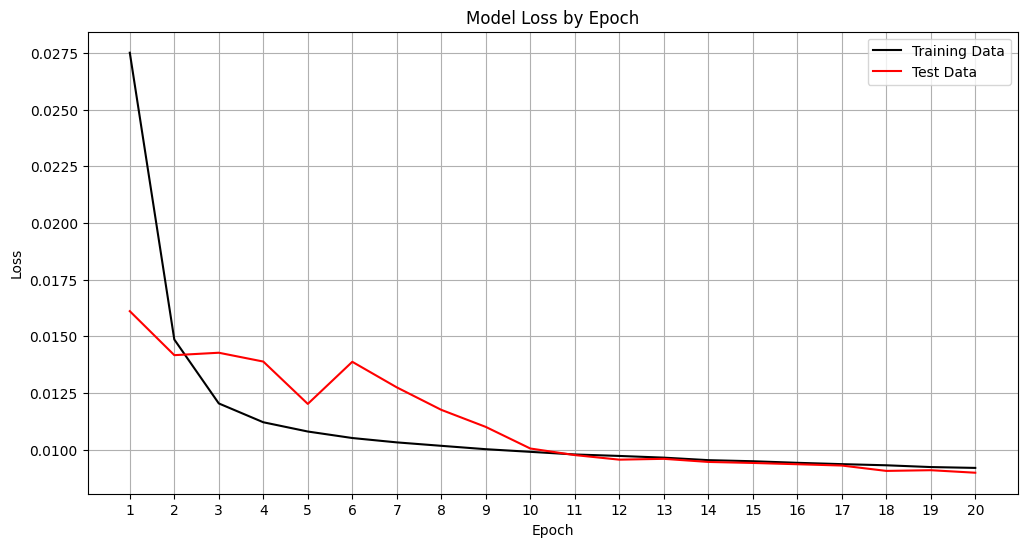

In [6]:
# Fit the Denoising autoencoder model to reconstruct original images
history = model.fit(X_train_noisy, X_train, epochs=20, batch_size=32, verbose=1, validation_data=(X_test_noisy, X_test))

# Plot a loss chart
fig, ax = plt.subplots(figsize=(12,6), dpi=100)
plt.title(label='Model Loss by Epoch', loc='center')
plt.grid(True)

ax.plot(history.history['loss'], label='Training Data', color='black')
ax.plot(history.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.xticks(ticks=np.arange(len(history.history['loss'])), labels=np.arange(1, len(history.history['loss'])+1))
plt.legend()

plt.show()

313/313 [==============================] - 1s 2ms/step


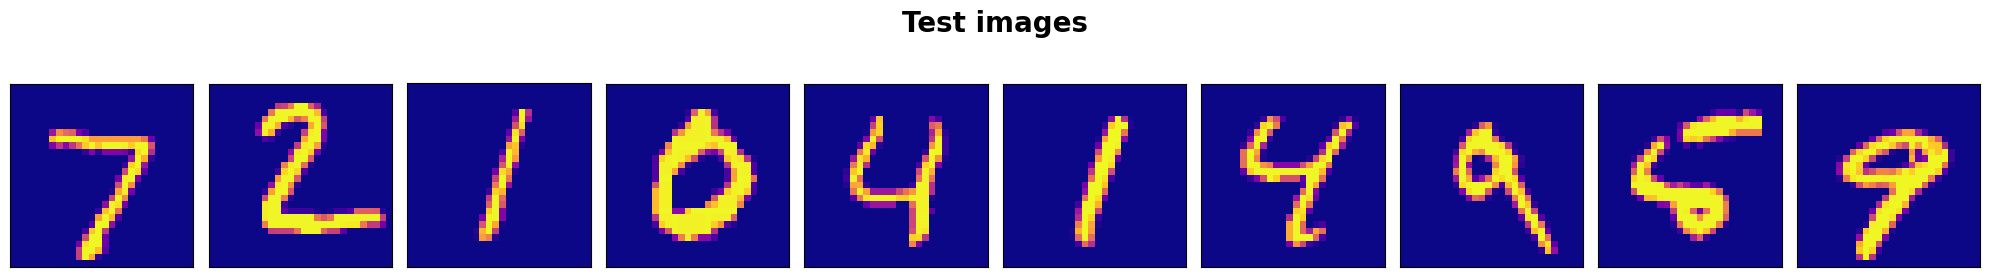

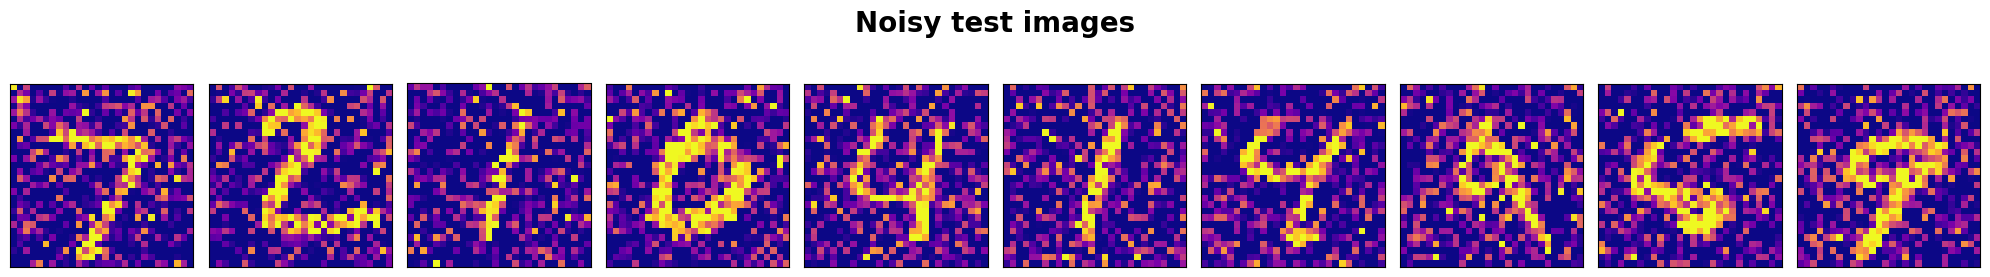

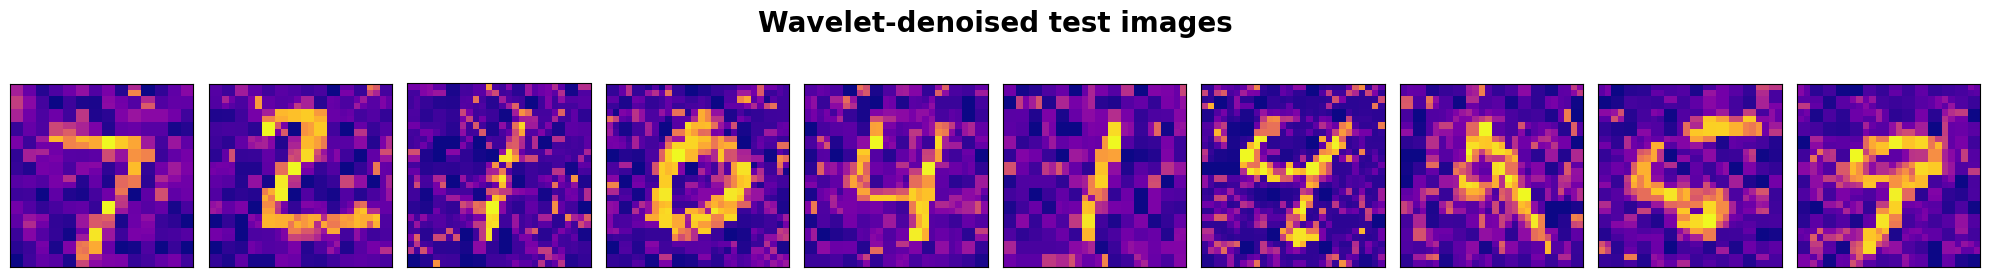

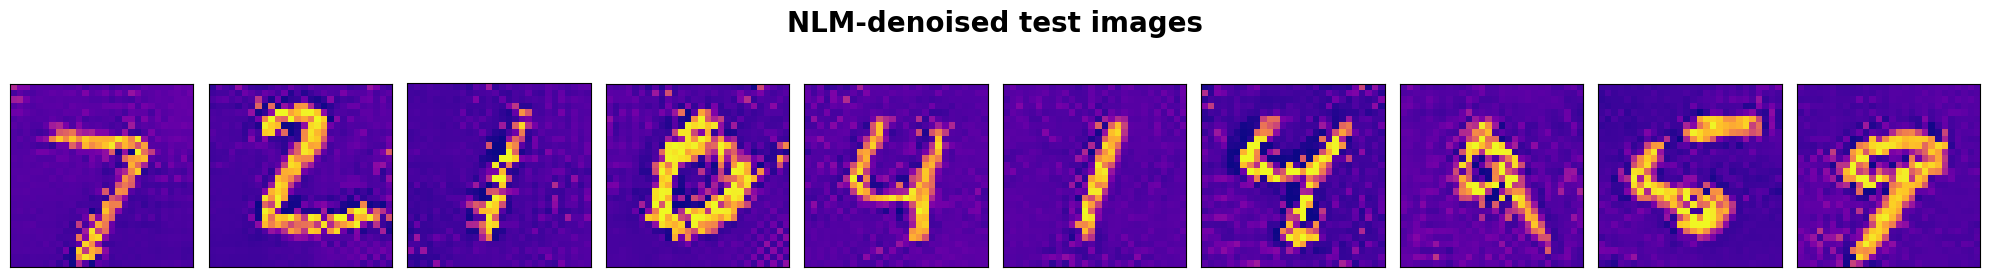

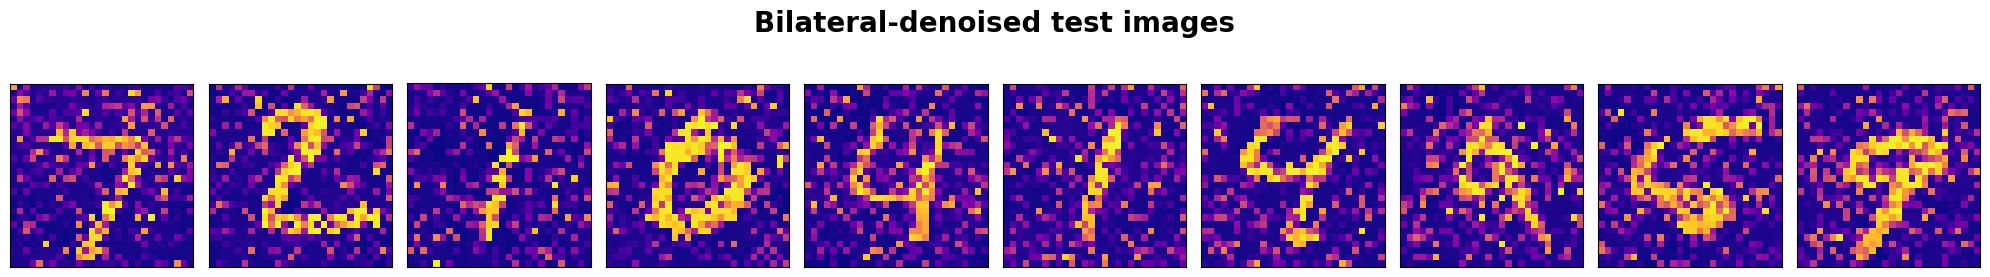

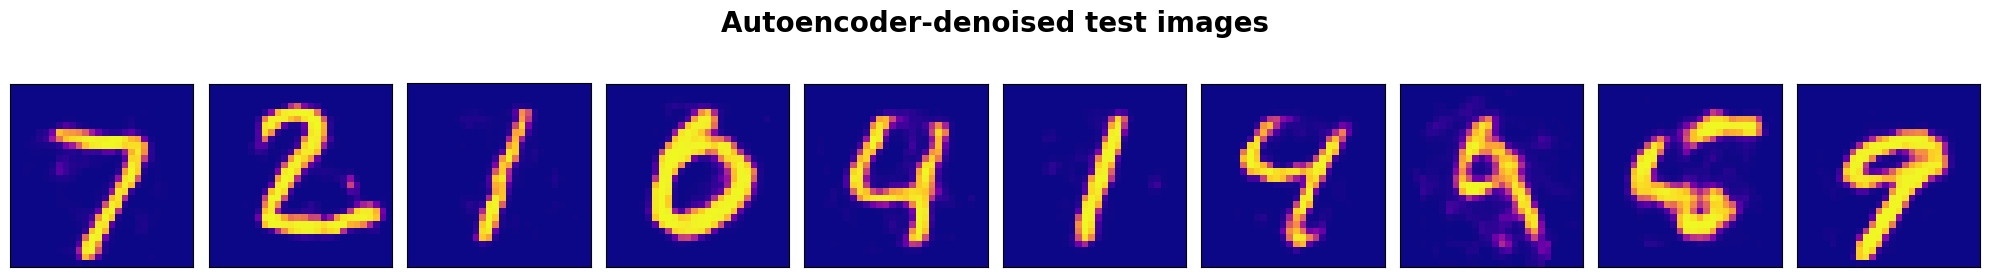

In [7]:
# Reshape back
X_test_back = X_test.reshape(10000, 28, 28)
X_test_noisy_reshaped = X_test_noisy.reshape(10000, 28, 28)
X_test_denoised = model.predict(X_test_noisy).reshape(10000, 28, 28)

# Original images
#-------------------------------------------------------------------------------

fig, axs = plt.subplots(1, 10, sharey=False, tight_layout=True, figsize=(20,3), facecolor='white')
n = 0
for j in range(0,10):
  axs[j].matshow(X_test_back[n], cmap='plasma')
  axs[j].set_xticks([])
  axs[j].set_yticks([])
  n = n + 1
fig.suptitle('Test images', fontsize=20, fontweight="bold")
plt.show()

# Noisy images
#-------------------------------------------------------------------------------

fig, axs = plt.subplots(1, 10, sharey=False, tight_layout=True, figsize=(20,3), facecolor='white')
n = 0
for j in range(0,10):
  axs[j].matshow(X_test_noisy_reshaped[n], cmap='plasma')
  axs[j].set_xticks([])
  axs[j].set_yticks([])
  n = n + 1
fig.suptitle('Noisy test images', fontsize=20, fontweight="bold")
plt.show()

# Wavelet-denoised images
#-------------------------------------------------------------------------------

wavDenoise = np.empty(np.shape(X_test_noisy_reshaped))

for j in range(0,10000):
  sigma_est = estimate_sigma(X_test_noisy_reshaped[j])
  wavDenoise[j] = denoise_wavelet(X_test_noisy_reshaped[j], channel_axis=None, method='BayesShrink', mode='soft', sigma=sigma_est, rescale_sigma=True)

fig, axs = plt.subplots(1, 10, sharey=False, tight_layout=True, figsize=(20,3), facecolor='white')
n = 0
for j in range(0,10):
  axs[j].matshow(wavDenoise[n], cmap='plasma')
  axs[j].set_xticks([])
  axs[j].set_yticks([])
  n = n + 1
fig.suptitle('Wavelet-denoised test images', fontsize=20, fontweight="bold")
plt.show()

# Non-local means-denoised images
#-------------------------------------------------------------------------------

nlmeansDenoise = np.empty(np.shape(X_test_noisy_reshaped))

for j in range(0,10000):
  sigma_est = estimate_sigma(X_test_noisy_reshaped[j])
  nlmeansDenoise[j] = denoise_nl_means(X_test_noisy_reshaped[j], patch_size=7, patch_distance=11, h=0.1, fast_mode=True, sigma=sigma_est, channel_axis=None)

fig, axs = plt.subplots(1, 10, sharey=False, tight_layout=True, figsize=(20,3), facecolor='white')
n = 0
for j in range(0,10):
  axs[j].matshow(nlmeansDenoise[n], cmap='plasma')
  axs[j].set_xticks([])
  axs[j].set_yticks([])
  n = n + 1
fig.suptitle('NLM-denoised test images', fontsize=20, fontweight="bold")
plt.show()

# Bilateral-denoised images
#-------------------------------------------------------------------------------

bilateralDenoise = np.empty(np.shape(X_test_noisy_reshaped))

for j in range(0,10000):
  sigma_est = estimate_sigma(X_test_noisy_reshaped[j])
  bilateralDenoise[j] = denoise_bilateral(X_test_noisy_reshaped[j], sigma_color=sigma_est, sigma_spatial=3, bins=10000, mode='wrap', channel_axis=None)

fig, axs = plt.subplots(1, 10, sharey=False, tight_layout=True, figsize=(20,3), facecolor='white')
n = 0
for j in range(0,10):
  axs[j].matshow(bilateralDenoise[n], cmap='plasma')
  axs[j].set_xticks([])
  axs[j].set_yticks([])
  n = n + 1
fig.suptitle('Bilateral-denoised test images', fontsize=20, fontweight="bold")
plt.show()

# Autoencoder-denoised images
#-------------------------------------------------------------------------------

fig, axs = plt.subplots(1, 10, sharey=False, tight_layout=True, figsize=(20,3), facecolor='white')
n = 0
for j in range(0,10):
  axs[j].matshow(X_test_denoised[n], cmap='plasma')
  axs[j].set_xticks([])
  axs[j].set_yticks([])
  n = n + 1
fig.suptitle('Autoencoder-denoised test images', fontsize=20, fontweight="bold")
plt.show()


In [8]:
# Performance evaluation

#-------------------------------------------------------------------------------
# https://github.com/aizvorski/video-quality/blob/master/ssim.py

def block_view(A, block=(3, 3)):
    shape = (A.shape[0]/ block[0], A.shape[1]/ block[1])+ block
    strides = (block[0]* A.strides[0], block[1]* A.strides[1])+ A.strides
    return ast(A, shape=map(int,shape), strides=map(int,strides))

def ssim(img1, img2, C1=0.01**2, C2=0.03**2):
    bimg1 = block_view(img1, (4,4))
    bimg2 = block_view(img2, (4,4))
    s1  = np.sum(bimg1, (-1, -2))
    s2  = np.sum(bimg2, (-1, -2))
    ss  = np.sum(bimg1*bimg1, (-1, -2)) + np.sum(bimg2*bimg2, (-1, -2))
    s12 = np.sum(bimg1*bimg2, (-1, -2))

    vari = ss - s1*s1 - s2*s2
    covar = s12 - s1*s2

    ssim_map =  (2*s1*s2 + C1) * (2*covar + C2) / ((s1*s1 + s2*s2 + C1) * (vari + C2))
    return np.mean(ssim_map)
#-------------------------------------------------------------------------------

RMSE = np.empty(10000)
RMSE_WAV = np.empty(10000)
RMSE_AUTO = np.empty(10000)
RMSE_NLM = np.empty(10000)
RMSE_BI = np.empty(10000)

for j in range(0,10000):
  RMSE[j] = np.sqrt(np.mean((X_test_noisy_reshaped[j] - X_test_back[j])**2))
  RMSE_WAV[j] = np.sqrt(np.mean((wavDenoise[j] - X_test_back[j])**2))
  RMSE_AUTO[j] = np.sqrt(np.mean((X_test_denoised[j] - X_test_back[j])**2))
  RMSE_NLM[j] = np.sqrt(np.mean((nlmeansDenoise[j] - X_test_back[j])**2))
  RMSE_BI[j] = np.sqrt(np.mean((bilateralDenoise[j] - X_test_back[j])**2))

print('---------------------------------------')
print('Average RMSE noisy images:', np.round(np.mean(RMSE),4),'\n')
print('Average RMSE wavelet: ', np.round(np.mean(RMSE_WAV),4), '\nAverage RMSE nlm: ', np.round(np.mean(RMSE_NLM),4), 
      '\nAverage RMSE bilateral: ', np.round(np.mean(RMSE_BI),4), '\nAverage RMSE autoencoder: ', np.round(np.mean(RMSE_AUTO),4))


PSNR = np.empty(10000)
PSNR_WAV = np.empty(10000)
PSNR_AUTO = np.empty(10000)
PSNR_NLM = np.empty(10000)
PSNR_BI = np.empty(10000)

for j in range(0,10000):
  PSNR[j] = 20*np.log10(1/RMSE[j])
  PSNR_WAV[j] = 20*np.log10(1/RMSE_WAV[j])
  PSNR_AUTO[j] = 20*np.log10(1/RMSE_AUTO[j])
  PSNR_NLM[j] = 20*np.log10(1/RMSE_NLM[j])
  PSNR_BI[j] = 20*np.log10(1/RMSE_BI[j])

print('---------------------------------------')
print('Average PSNR noisy images:', np.round(np.mean(PSNR),2),'dB\n')
print('Average PSNR wavelet: ', np.round(np.mean(PSNR_WAV),2), 'dB\nAverage PSNR nlm: ', np.round(np.mean(PSNR_NLM),2), 
      'dB\nAverage PSNR bilateral: ', np.round(np.mean(PSNR_BI),2), 'dB\nAverage PSNR autoencoder: ', np.round(np.mean(PSNR_AUTO),2),'dB')

SSIM = np.empty(10000)
SSIM_WAV = np.empty(10000)
SSIM_AUTO = np.empty(10000)
SSIM_NLM = np.empty(10000)
SSIM_BI = np.empty(10000)

for j in range(0,10000):
  SSIM[j] = ssim(X_test_noisy_reshaped[j], X_test_back[j]) 
  SSIM_WAV[j] = ssim(wavDenoise[j], X_test_back[j])
  SSIM_AUTO[j] = ssim(X_test_denoised[j], X_test_back[j])
  SSIM_NLM[j] = ssim(nlmeansDenoise[j], X_test_back[j])
  SSIM_BI[j] = ssim(bilateralDenoise[j], X_test_back[j])

print('---------------------------------------')
print('Average SSIM noisy images:', np.round(np.mean(SSIM),2),'\n')
print('Average SSIM wavelet: ', np.round(np.mean(SSIM_WAV),2), '\nAverage SSIM nlm: ', np.round(np.mean(SSIM_NLM),2), 
      '\nAverage SSIM bilateral: ', np.round(np.mean(SSIM_BI),2), '\nAverage SSIM autoencoder: ', np.round(np.mean(SSIM_AUTO),2))
print('---------------------------------------')

---------------------------------------
Average RMSE noisy images: 0.274 

Average RMSE wavelet:  0.2172 
Average RMSE nlm:  0.1841 
Average RMSE bilateral:  0.2396 
Average RMSE autoencoder:  0.0917
---------------------------------------
Average PSNR noisy images: 11.25 dB

Average PSNR wavelet:  13.27 dB
Average PSNR nlm:  14.72 dB
Average PSNR bilateral:  12.42 dB
Average PSNR autoencoder:  20.93 dB
---------------------------------------
Average SSIM noisy images: 0.29 

Average SSIM wavelet:  0.29 
Average SSIM nlm:  0.29 
Average SSIM bilateral:  0.3 
Average SSIM autoencoder:  0.66
---------------------------------------
